# DenseNet201 Ultrasound Training (No Pretrained Weights) with Test Set Evaluation

## Overview
This notebook trains a DenseNet201 model from scratch (without ImageNet pretraining) for liver fibrosis classification using ultrasound images.

## Key Features
- **Data Split**: 65% training, 20% validation (cross-validation), 15% test
- **Stratified Sampling**: All splits maintain the original class distribution
- **Cross-Validation**: 5-fold stratified cross-validation on training data for robust validation metrics
- **Test Set Evaluation**: Final model performance evaluated exclusively on held-out test set
- **Early Stopping**: Training stops if no validation improvement for 6 epochs
- **Model Architecture**: DenseNet201 with custom classifier for multi-class fibrosis stage prediction

## Workflow
1. Load and preprocess ultrasound dataset
2. Create stratified train/val/test splits
3. Set up 5-fold cross-validation on training data
4. Train DenseNet201 with early stopping
5. Evaluate final model on test set
6. Generate confusion matrix and classification report

## Import Required Libraries

In [1]:
import os
import random
import time
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torchvision import transforms, datasets, models
from tqdm import tqdm
from sklearn.model_selection import train_test_split, StratifiedKFold
from PIL import Image


In [2]:
import gc
gc.collect()
torch.cuda.empty_cache()


## Import the dataset

In [3]:
#dataset_path = 'C:\\Users\\RAZER\\Documents\\GitHub\\IUT_Project_2025\\LIVER\\Liver Fibosis US-20251223T180246Z-1-002\\Liver Fibosis US\\Liver_Fibrosis_US'


dataset_path = 'C:\\Users\\user\\Documents\\GitHub\\IUT_Project_2025\\LIVER\\Liver Fibosis US-20251223T180246Z-1-002\\Liver Fibosis US\\Liver_Fibrosis_US'



In [4]:
print(os.listdir(dataset_path))


['F0', 'F1', 'F2', 'F3', 'F4']


In [5]:
classes = os.listdir(dataset_path)
print(classes)


['F0', 'F1', 'F2', 'F3', 'F4']


## Train DenseNet201

Test mode only uses 5 images per class for training to allow a quick smoke test. Set to False for full training.

In [6]:
test_mode = False


### Hyperparameters

In [7]:
use_gpu = True  
random_seed = 42

# Hyperparameters 
batch_size = 8 if not test_mode else 8
num_epochs = 30 if not test_mode else 5
learning_rate = 1e-4
num_workers = 4
patience = 6
device = torch.device('cuda' if (use_gpu and torch.cuda.is_available()) else 'cpu')
print('Using device:', device)
torch.manual_seed(random_seed)
random.seed(random_seed)
np.random.seed(random_seed)


Using device: cuda


### Train-Val-Test Split with Stratification and Cross-Validation

In [8]:
# Custom letterbox rescaling transform
class LetterboxRescale:
    def __init__(self, target_h=480, target_w=640):
        self.target_h = target_h
        self.target_w = target_w
    
    def __call__(self, img):
        """
        Apply letterbox rescaling to preserve aspect ratio.
        Pads with black (0) to reach target dimensions.
        Converts grayscale to RGB for DenseNet compatibility.
        """
        if isinstance(img, np.ndarray):
            img = Image.fromarray(img)
        
        # Convert grayscale to RGB (repeat single channel 3 times)
        if img.mode == 'L':
            img = img.convert('RGB')
        elif img.mode != 'RGB':
            img = img.convert('RGB')
        
        w, h = img.size
        
        # Calculate scale factor to fit within target dimensions
        scale = min(self.target_h / h, self.target_w / w)
        new_w = int(round(w * scale))
        new_h = int(round(h * scale))
        
        # Resize image preserving aspect ratio
        resized = img.resize((new_w, new_h), Image.BICUBIC)
        
        # Create black canvas (RGB mode now)
        canvas = Image.new('RGB', (self.target_w, self.target_h), (0, 0, 0))
        
        # Calculate position to center the image
        left = (self.target_w - new_w) // 2
        top = (self.target_h - new_h) // 2
        
        # Paste resized image on canvas
        canvas.paste(resized, (left, top))
        
        return canvas

# Create transforms with letterbox rescaling
letterbox_transform = transforms.Compose([
    LetterboxRescale(target_h=480, target_w=640),
    transforms.ToTensor(),
])

# Create ImageFolder dataset with letterbox rescaling
full_dataset = datasets.ImageFolder(dataset_path, transform=letterbox_transform)
classes = full_dataset.classes
num_classes = len(classes)
print('Found classes:', classes)

# Extract all indices and their corresponding labels for stratification
all_indices = np.arange(len(full_dataset))
all_labels = np.array([label for _, label in full_dataset.samples])

# First split: train+val (85%) and test (15%) - stratified by class
train_val_indices, test_indices, _, test_labels = train_test_split(
    all_indices, all_labels,
    test_size=0.15,
    random_state=random_seed,
    stratify=all_labels
)

# Second split: train (65% of total = ~76% of train_val) and val (20% of total = ~24% of train_val) - stratified by class
train_val_labels = all_labels[train_val_indices]
train_indices, val_indices, _, _ = train_test_split(
    train_val_indices, train_val_labels,
    test_size=0.2353,  # 20% of 85% = 0.20/0.85 ≈ 0.2353
    random_state=random_seed,
    stratify=train_val_labels
)

print(f'Train samples: {len(train_indices)}, Val samples: {len(val_indices)}, Test samples: {len(test_indices)}')
print(f'Data split: Train={len(train_indices)/len(full_dataset)*100:.1f}%, Val={len(val_indices)/len(full_dataset)*100:.1f}%, Test={len(test_indices)/len(full_dataset)*100:.1f}%')

# Create Subset datasets
train_dataset = Subset(full_dataset, train_indices)
val_dataset = Subset(full_dataset, val_indices)
test_dataset = Subset(full_dataset, test_indices)



Found classes: ['F0', 'F1', 'F2', 'F3', 'F4']
Train samples: 2181, Val samples: 672, Test samples: 504
Data split: Train=65.0%, Val=20.0%, Test=15.0%


### Stratified K-Fold Cross-Validation Setup

In [9]:
# Set up stratified k-fold cross-validation on training data
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_seed)

# Get training labels for stratification
train_labels = all_labels[train_indices]

# Store fold information
fold_splits = []
for fold_idx, (train_fold_idx, val_fold_idx) in enumerate(skf.split(train_indices, train_labels)):
    fold_splits.append((train_fold_idx, val_fold_idx))

print(f'Cross-validation setup: {n_splits}-fold stratified cross-validation')
print(f'Each fold: ~{len(train_fold_idx)/len(train_indices)*100:.1f}% training, ~{len(val_fold_idx)/len(train_indices)*100:.1f}% validation')


Cross-validation setup: 5-fold stratified cross-validation
Each fold: ~80.0% training, ~20.0% validation


### Create DataLoaders for Test Set

In [10]:
# Create data loaders for training and validation datasets
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

print(f'Train loader created with {len(train_dataset)} samples')
print(f'Val loader created with {len(val_dataset)} samples')


Train loader created with 2181 samples
Val loader created with 672 samples


In [11]:
# Create test loader (will be used after training for final evaluation)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

# DataLoaders for each fold will be created dynamically during training
print(f'Test loader created with {len(test_dataset)} samples')
print(f'Fold splits prepared for training phase')


Test loader created with 504 samples
Fold splits prepared for training phase


### Model Config

In [12]:
# Build model
model = models.densenet201(pretrained=False)

# Replace classifier
in_features = model.classifier.in_features
model.classifier = nn.Linear(in_features, num_classes)
model = model.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
# Scheduler optional
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)


c:\Users\RAZER\miniconda3\envs\torch_on\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\RAZER\miniconda3\envs\torch_on\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [13]:
def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    pbar = tqdm(loader, desc='Train', leave=False)
    for inputs, targets in pbar:
        inputs = inputs.to(device)
        targets = targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == targets).sum().item()
        total += targets.size(0)
        pbar.set_postfix(loss=running_loss/total, acc=100. * correct/total)
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc


def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_targets = []
    all_preds = []
    all_probs = []
    with torch.no_grad():
        pbar = tqdm(loader, desc='Eval', leave=False)
        for inputs, targets in pbar:
            inputs = inputs.to(device)
            targets = targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            running_loss += loss.item() * inputs.size(0)
            probs = torch.softmax(outputs, dim=1)
            _, preds = torch.max(outputs, 1)
            correct += (preds == targets).sum().item()
            total += targets.size(0)
            all_targets.extend(targets.cpu().tolist())
            all_preds.extend(preds.cpu().tolist())
            all_probs.extend(probs.cpu().tolist())
    epoch_loss = running_loss / total if total>0 else 0
    epoch_acc = correct / total if total>0 else 0
    return epoch_loss, epoch_acc, all_targets, all_preds, all_probs


### Training Loop

In [ ]:
# Store results for each fold
fold_histories = []
fold_best_accs = []
fold_models = []

# Train a model for each fold
for fold_idx, (train_fold_idx, val_fold_idx) in enumerate(fold_splits):
    print(f'\n{"="*60}')
    print(f'Training Fold {fold_idx + 1}/{n_splits}')
    print(f'{"="*60}')
    
    # Create fold-specific datasets
    fold_train_dataset = Subset(train_dataset, train_fold_idx)
    fold_val_dataset = Subset(train_dataset, val_fold_idx)
    
    # Create fold-specific dataloaders
    fold_train_loader = DataLoader(fold_train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    fold_val_loader = DataLoader(fold_val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    
    print(f'Fold {fold_idx + 1}: Train={len(fold_train_dataset)}, Val={len(fold_val_dataset)}')
    
    # Reinitialize model for this fold
    fold_model = models.densenet201(pretrained=False)
    in_features = fold_model.classifier.in_features
    fold_model.classifier = nn.Linear(in_features, num_classes)
    fold_model = fold_model.to(device)
    
    # Reinitialize optimizer and scheduler for this fold
    fold_criterion = nn.CrossEntropyLoss()
    fold_optimizer = optim.Adam(fold_model.parameters(), lr=learning_rate)
    fold_scheduler = optim.lr_scheduler.StepLR(fold_optimizer, step_size=7, gamma=0.1)
    
    # Training loop for this fold
    fold_history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    fold_best_val_acc = 0.0
    fold_best_model_wts = None
    fold_epochs_without_improvement = 0
    
    for epoch in range(num_epochs):
        fold_train_loss, fold_train_acc = train_one_epoch(fold_model, fold_train_loader, fold_criterion, fold_optimizer, device)
        fold_val_loss, fold_val_acc, _, _, _ = evaluate(fold_model, fold_val_loader, fold_criterion, device)
        fold_scheduler.step()
        
        fold_history['train_loss'].append(fold_train_loss)
        fold_history['train_acc'].append(fold_train_acc)
        fold_history['val_loss'].append(fold_val_loss)
        fold_history['val_acc'].append(fold_val_acc)
        
        print(f"  Epoch {epoch+1}/{num_epochs} | Train loss: {fold_train_loss:.4f} acc: {fold_train_acc:.4f} | Val loss: {fold_val_loss:.4f} acc: {fold_val_acc:.4f}")
        
        if fold_val_acc > fold_best_val_acc:
            fold_best_val_acc = fold_val_acc
            fold_best_model_wts = {k: v.cpu() for k, v in fold_model.state_dict().items()}
            fold_epochs_without_improvement = 0
        else:
            fold_epochs_without_improvement += 1
        
        # Early stopping
        if fold_epochs_without_improvement >= patience:
            print(f'  Early stopping: no improvement for {patience} epochs')
            break
    
    # Load best weights for this fold
    if fold_best_model_wts is not None:
        fold_model.load_state_dict(fold_best_model_wts)
    
    fold_histories.append(fold_history)
    fold_best_accs.append(fold_best_val_acc)
    fold_models.append(fold_model)
    
    print(f'Fold {fold_idx + 1} complete. Best val acc: {fold_best_val_acc:.4f}')

print(f'\n{"="*60}')
print(f'Cross-Validation Summary')
print(f'{"="*60}')
print(f'Fold accuracies: {[f"{acc:.4f}" for acc in fold_best_accs]}')
print(f'Mean CV Accuracy: {np.mean(fold_best_accs):.4f} (+/- {np.std(fold_best_accs):.4f})')



Training Fold 1/5
Fold 1: Train=1744, Val=437


Train:   0%|          | 0/218 [00:00<?, ?it/s]

### Loading the model

In [ ]:
### Select Best Fold Model and Evaluate on Test Set

# Select the model with best validation accuracy across all folds
best_fold_idx = np.argmax(fold_best_accs)
best_model = fold_models[best_fold_idx]

print(f'Best performing fold: Fold {best_fold_idx + 1} with validation accuracy: {fold_best_accs[best_fold_idx]:.4f}')
print(f'Using this model for final test set evaluation...\n')

# Evaluate best model on test set
test_loss, test_acc, test_targets, test_preds, test_probs = evaluate(best_model, test_loader, criterion, device)
print(f'Final Test Loss: {test_loss:.4f}')
print(f'Final Test Accuracy: {test_acc:.4f}')


Best performing fold: Fold 2 with validation accuracy: 0.9647
Using this model for final test set evaluation...



Final Test Loss: 0.1463
Final Test Accuracy: 0.9494


### Plotting Training Curves

NameError: name 'history' is not defined

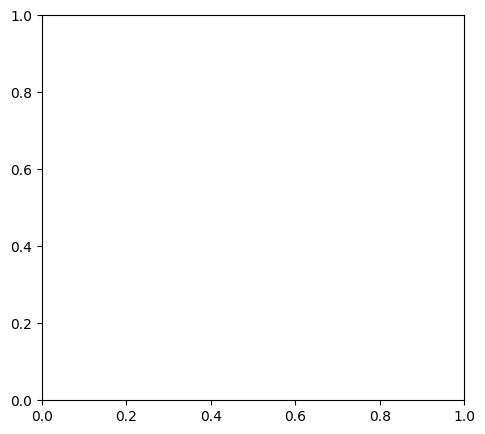

In [16]:
# Plot training curves
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history['train_loss'], label='train_loss')
plt.plot(history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss')
plt.subplot(1,2,2)
plt.plot([x*100 for x in history['train_acc']], label='train_acc')
plt.plot([x*100 for x in history['val_acc']], label='val_acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('Accuracy')
plt.show()
# Confusion matrix (small datasets may have classes missing in test)
try:
    from sklearn.metrics import confusion_matrix, classification_report
    cm = confusion_matrix(test_targets, test_preds, labels=list(range(num_classes)))
    plt.figure(figsize=(6,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Test Set Confusion Matrix')
    plt.show()
    print('\nTest Set Classification report:')
    print(classification_report(test_targets, test_preds, target_names=classes, zero_division=0))
except Exception as e:
    print('Could not compute confusion matrix or classification report:', e)


### Exporting the Model

In [ ]:
# Export model
out_dir = Path('outputs')
out_dir.mkdir(parents=True, exist_ok=True)

# Save state_dict
torch.save(model.state_dict(), out_dir / 'densenet201_state_dict.pth')

# Save full model (may be large)
torch.save(model, out_dir / 'densenet201_full_model.pt')

print(f'Saved model to {out_dir}')
print(f'  - State dict: {out_dir / "densenet201_state_dict.pth"}')
print(f'  - Full model: {out_dir / "densenet201_full_model.pt"}')
